In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import warnings
import math
from collections import namedtuple
warnings.filterwarnings("ignore")
import TitanicUtils as tu

%matplotlib inline 

In [2]:
#Helper functions for the data processing
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    #print(big_string)
    return np.nan

def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Mr', 'Master']:
        return -1
    elif title in ['Countess', 'Mme', 'Mrs']:
        return 0
    elif title in ['Mlle', 'Ms', 'Miss']:
        return 1
    elif title =='Dr':
        if x['Sex']==1:
            return 0
        else:
            return 1
    else:
        return title 

#The data processing for the training and testing data sets
def data_train():
    train_data = pd.read_csv("train.csv")
    
    #Turning cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    train_data['Cabin'] = train_data['Cabin'].astype(str)
    train_data['Deck'] = train_data['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    
    train_data.loc[(train_data.Deck == 'A'),'Deck'] = -1
    train_data.loc[(train_data.Deck == 'B'),'Deck'] = -.75
    train_data.loc[(train_data.Deck == 'C'),'Deck'] = -.5
    train_data.loc[(train_data.Deck == 'D'),'Deck'] = -.25
    train_data.loc[(train_data.Deck == 'E'),'Deck'] = .25
    train_data.loc[(train_data.Deck == 'F'),'Deck'] = .5
    train_data.loc[(train_data.Deck == 'T'),'Deck'] = .75
    train_data.loc[(train_data.Deck == 'G'),'Deck'] = 1
    train_data["Deck"] = train_data["Deck"].fillna(0)
    
    #Creating new family_size column
    train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch']
    
    train_data['Age*Class'] = train_data['Age'] * train_data['Pclass']
    
    train_data['Fare_Per_Person'] = train_data['Fare']  / (train_data['Family_Size']+1)

    train_data.loc[(train_data.Sex == 'female'),'Sex'] = -1
    train_data.loc[(train_data.Sex == 'male'),'Sex'] = 1

    train_data.loc[(train_data.Embarked == 'C'),'Embarked'] = -1
    train_data.loc[(train_data.Embarked == 'Q'),'Embarked'] = 1
    train_data.loc[(train_data.Embarked == 'S'),'Embarked'] = 2
    train_data["Embarked"] = train_data["Embarked"].fillna(0)

    train_data.loc[(train_data.Pclass == 1),'Pclass'] = 1
    train_data.loc[(train_data.Pclass == 2),'Pclass'] = 0
    train_data.loc[(train_data.Pclass == 3),'Pclass'] = -1
    
    train_data['Sex*Class'] = train_data['Sex'] * train_data['Pclass']
    
    train_data["Age"] = train_data["Age"].fillna(0)
    
    train_data["Age*Class"] = train_data["Age*Class"].fillna(0)
    
    train_data['Embarked*Class'] = train_data['Embarked'] * train_data['Pclass']
    
    train_data['Age*Deck'] = train_data['Age'] * train_data['Deck']
    
    #train_data["Embarked*Class"] = train_data["Embarked*Class"].fillna(0)

    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                        'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                        'Don', 'Jonkheer']

    train_data['Title'] = train_data['Name'].map(lambda x: substrings_in_string(x, title_list))   
    train_data['Title'] = train_data.apply(replace_titles, axis=1)
    
    train_data['Title*Class'] = train_data['Title'] * train_data['Pclass']

    tmp = train_data[['Pclass', 'Title', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck', 'Title*Class',
                      'Family_Size', 'Age*Class', 'Fare_Per_Person', 'Embarked*Class', 'Sex*Class', 'Age*Deck']].copy()
    
    X = pd.DataFrame(tmp).to_numpy()
    X = X.T
    Y = np.array([train_data['Survived'].values])

    X = np.float32(X)
    Y = np.float32(Y)
    m = X.shape[1]  
    #Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuff_X = X[:, permutation]
    shuff_Y = Y[:, permutation].reshape((1,m))

    devM = round(m * .05)
    devM2 = m - devM
    
    train_X = shuff_X[:, 0:(devM2)]
    train_Y = shuff_Y[:, 0:(devM2)]
    dev_X = shuff_X[:, -(devM + 1):-1]
    dev_Y = shuff_Y[:, -(devM + 1):-1]
    
    m_train = train_X.shape[1]
    m_test = dev_X.shape[1]
    
    print ("Number of training examples: m_train = " + str(m_train))
    print ("Number of testing examples: m_test = " + str(m_test))
    print ("train_set_x shape: " + str(train_X.shape))
    print ("train_set_y shape: " + str(train_Y.shape))
    print ("test_set_x shape: " + str(dev_X.shape))
    print ("test_set_y shape: " + str(dev_Y.shape))
    
    return train_X, train_Y, dev_X, dev_Y

#The data processing for the submission data sets
def data_test():
    test_data = pd.read_csv("test.csv")
    
    #Turning cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    test_data['Cabin'] = test_data['Cabin'].astype(str)
    test_data['Deck'] = test_data['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    
    test_data.loc[(test_data.Deck == 'A'),'Deck'] = -1
    test_data.loc[(test_data.Deck == 'B'),'Deck'] = -.75
    test_data.loc[(test_data.Deck == 'C'),'Deck'] = -.5
    test_data.loc[(test_data.Deck == 'D'),'Deck'] = -.25
    test_data.loc[(test_data.Deck == 'E'),'Deck'] = .25
    test_data.loc[(test_data.Deck == 'F'),'Deck'] = .5
    test_data.loc[(test_data.Deck == 'T'),'Deck'] = .75
    test_data.loc[(test_data.Deck == 'G'),'Deck'] = 1
    test_data["Deck"] = test_data["Deck"].fillna(0)
    
    #Creating new family_size column
    test_data['Family_Size'] = test_data['SibSp'] + test_data['Parch']
    
    test_data['Age*Class'] = test_data['Age'] * test_data['Pclass']
    
    test_data['Fare_Per_Person'] = test_data['Fare']  / (test_data['Family_Size']+1)

    test_data.loc[(test_data.Sex == 'female'),'Sex'] = -1
    test_data.loc[(test_data.Sex == 'male'),'Sex'] = 1

    test_data.loc[(test_data.Embarked == 'C'),'Embarked'] = -1
    test_data.loc[(test_data.Embarked == 'Q'),'Embarked'] = 1
    test_data.loc[(test_data.Embarked == 'S'),'Embarked'] = 2
    test_data["Embarked"] = test_data["Embarked"].fillna(0)

    test_data.loc[(test_data.Pclass == 1),'Pclass'] = 1
    test_data.loc[(test_data.Pclass == 2),'Pclass'] = 0
    test_data.loc[(test_data.Pclass == 3),'Pclass'] = -1
    
    test_data['Sex*Class'] = test_data['Sex'] * test_data['Pclass']
    
    test_data["Age"] = test_data["Age"].fillna(0)
    
    test_data["Age*Class"] = test_data["Age*Class"].fillna(0)
    
    test_data['Embarked*Class'] = test_data['Embarked'] * test_data['Pclass']
    
    test_data['Age*Deck'] = test_data['Age'] * test_data['Deck']
    
    #test_data["Embarked*Class"] = test_data["Embarked*Class"].fillna(0)

    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                        'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                        'Don', 'Jonkheer']

    test_data['Title'] = test_data['Name'].map(lambda x: substrings_in_string(x, title_list))   
    test_data['Title'] = test_data.apply(replace_titles, axis=1)
    
    test_data['Title*Class'] = test_data['Title'] * test_data['Pclass']

    tmp = test_data[['Pclass', 'Title', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck', 'Title*Class',
                      'Family_Size', 'Age*Class', 'Fare_Per_Person', 'Embarked*Class', 'Sex*Class', 'Age*Deck']].copy()
    
    X = pd.DataFrame(tmp).to_numpy()
    X = X.T

    X = np.float32(X)
    
    test = X[:, :]
    
    return test

In [3]:
def backward_propagation(X, Y, tmpcache, lambd = 0):
    """
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    cache = {}
    (a0, z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3, z4, a4, W4, b4, z5, a5, W5, b5, z6, a6, W6, b6) = tmpcache

    for l in range(6):
        zkey = 'z' + str(l+1)
        akey = 'a' + str(l+1)
        Wkey = 'W' + str(l+1)
        bkey = 'b' + str(l+1)
        cache[Wkey] = tmpcache[Wkey]
        cache[bkey] = tmpcache[bkey]
        cache[zkey] = tmpcache[zkey]
        cache[akey] = tmpcache[akey]

        
    #dW3 = 1./m * np.dot(dZ3, A2.T) + ((lambd / m) * W3)
    
    if lambd > 0:
        dz6 = 1./m * (cache['a6'] - Y)
        dW6 = np.dot(dz6, cache['a5'].T) + ((lambd / m) * cache['W6'])
        db6 = np.sum(dz6, axis=1, keepdims = True)  
        dz5 = np.dot(cache['W6'].T, dz6) * (1 - np.power(cache['a5'], 2))
        dW5 = np.dot(dz5, cache['a4'].T) + ((lambd / m) * cache['W5'])
        db5 = np.sum(dz5, axis=1, keepdims = True)
        dz4 = np.dot(cache['W5'].T, dz5) * (1 - np.power(cache['a4'], 2))
        dW4 = np.dot(dz4, cache['a3'].T) + ((lambd / m) * cache['W4'])
        db4 = np.sum(dz4, axis=1, keepdims = True)
        dz3 = np.dot(cache['W4'].T, dz4) * (1 - np.power(cache['a3'], 2))
        dW3 = np.dot(dz3, cache['a2'].T) + ((lambd / m) * cache['W3'])
        db3 = np.sum(dz3, axis=1, keepdims = True)
        dz2 = np.dot(cache['W3'].T, dz3) * (1 - np.power(cache['a2'], 2))
        dW2 = np.dot(dz2, cache['a1'].T) + ((lambd / m) * cache['W2'])
        db2 = np.sum(dz2, axis=1, keepdims = True)
        dz1 = np.dot(cache['W2'].T, dz2) * (1 - np.power(cache['a1'], 2))
        dW1 = np.dot(dz1, X.T) + ((lambd / m) * cache['W1'])
        db1 = np.sum(dz1, axis=1, keepdims = True)
    else:
        dz6 = 1./m * (cache['a6'] - Y)
        dW6 = np.dot(dz6, cache['a5'].T)
        db6 = np.sum(dz6, axis=1, keepdims = True)  
        dz5 = np.dot(cache['W6'].T, dz6) * (1 - np.power(cache['a5'], 2))
        dW5 = np.dot(dz5, cache['a4'].T)
        db5 = np.sum(dz5, axis=1, keepdims = True)
        dz4 = np.dot(cache['W5'].T, dz5) * (1 - np.power(cache['a4'], 2))
        dW4 = np.dot(dz4, cache['a3'].T)
        db4 = np.sum(dz4, axis=1, keepdims = True)
        dz3 = np.dot(cache['W4'].T, dz4) * (1 - np.power(cache['a3'], 2))
        dW3 = np.dot(dz3, cache['a2'].T)
        db3 = np.sum(dz3, axis=1, keepdims = True)
        dz2 = np.dot(cache['W3'].T, dz3) * (1 - np.power(cache['a2'], 2))
        dW2 = np.dot(dz2, cache['a1'].T)
        db2 = np.sum(dz2, axis=1, keepdims = True)
        dz1 = np.dot(cache['W2'].T, dz2) * (1 - np.power(cache['a1'], 2))
        dW1 = np.dot(dz1, X.T)
        db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz6": dz6, "dW6": dW6, "db6": db6,
                 "dz5": dz5, "dW5": dW5, "db5": db5,
                 "dz4": dz4, "dW4": dW4, "db4": db4,
                 "dz3": dz3, "dW3": dW3, "db3": db3,
                 "dz2": dz2, "dW2": dW2, "db2": db2,
                 "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

In [4]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, beta = 0.9, lambd = 0,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = tu.initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = tu.initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = tu.initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):

        # Forward propagation and back prop
        if lambd > 0:
            cost, cache = tu.forward_propagation(X, Y, parameters, lambd)
            grads = backward_propagation(X, Y, cache, lambd)
        else:
            cost, cache = tu.forward_propagation(X, Y, parameters)
            grads = backward_propagation(X, Y, cache)

        # Update parameters
        if optimizer == "gd":
            parameters = tu.update_parameters_with_gd(parameters, grads, learning_rate)
        elif optimizer == "momentum":
            parameters, v = tu.update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
        elif optimizer == "adam":
            t = t + 1 # Adam counter
            parameters, v, s = tu.update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)

        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [5]:
X_assess, Y, parameters = tu.forward_propagation_test_case()
_, cache = tu.forward_propagation(X_assess, Y, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['z1']) ,np.mean(cache['a1']),np.mean(cache['z2']),np.mean(cache['a2']))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


**Expected Output**:
<table style="width:50%">
  <tr>
    <td> 0.262818640198 0.091999045227 -1.30766601287 0.212877681719 </td> 
  </tr>
</table>

In [6]:
A3, Y_assess, parameters = tu.compute_cost_with_regularization_test_case()

print("cost = " + str(tu.compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


**Expected Output**: 

<table> 
    <tr>
    <td>
    **cost**
    </td>
        <td>
    1.78648594516
    </td>
    </tr>

</table> 

In [7]:
X, Y, parameters = tu.gradient_check_test_case()
cost, cache = tu.forward_propagation(X, Y, parameters)
gradients = backward_propagation(X, Y, cache)
difference = tu.gradient_check(parameters, gradients, X, Y)
lambd = 0.7
gradients = backward_propagation(X, Y, cache, lambd = lambd)
difference = tu.gradient_check(parameters, gradients, X, Y, lambd = lambd)

Your backward propagation works perfectly fine! difference = 9.86774593024366e-09
Your backward propagation works perfectly fine! difference = 1.6953480311484942e-07


Number of training examples: m_train = 846
Number of testing examples: m_test = 45
train_set_x shape: (16, 846)
train_set_y shape: (1, 846)
test_set_x shape: (16, 45)
test_set_y shape: (1, 45)
Cost after epoch 0: 0.719571
Cost after epoch 1000: 0.375725
Cost after epoch 2000: 0.330159
Cost after epoch 3000: 0.325598
Cost after epoch 4000: 0.324747
Cost after epoch 5000: 0.324423
Cost after epoch 6000: 0.324174
Cost after epoch 7000: 0.323972
Cost after epoch 8000: 0.320023
Cost after epoch 9000: 0.319706
Cost after epoch 10000: 0.331446
Cost after epoch 11000: 0.324017
Cost after epoch 12000: 0.319190
Cost after epoch 13000: 0.318951
Cost after epoch 14000: 0.318812
Cost after epoch 15000: 0.321125
Cost after epoch 16000: 0.313899
Cost after epoch 17000: 0.313790
Cost after epoch 18000: 0.316584
Cost after epoch 19000: 0.313699
Cost after epoch 20000: 0.316466
Cost after epoch 21000: 0.316440
Cost after epoch 22000: 0.316373
Cost after epoch 23000: 0.313535
Cost after epoch 24000: 0.31

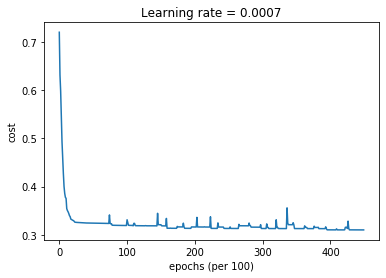

Accuracy: 0.9066193853427896
Accuracy: 0.8


In [8]:
train_X, train_Y, dev_X, dev_Y = data_train()

X = train_X
Y = train_Y
layers_dims = [train_X.shape[0], 32, 16, 8, 4, 2, 1]
optimizer = "adam"
learning_rate = 0.0007
beta = 0.9
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
num_epochs = 45000
print_cost = True
lambd = .07

parameters = model(X, Y, layers_dims, optimizer = optimizer, learning_rate = learning_rate, num_epochs = num_epochs, 
                   lambd = lambd, beta = beta, beta1 = beta1, beta2 = beta2, epsilon = epsilon, print_cost = print_cost)

# Predict
predictions = tu.predict(train_X, train_Y, parameters)
predictions1 = tu.predict(dev_X, dev_Y, parameters)

In [9]:
test_X = data_test()
results = tu.predict_t(test_X, parameters)
results = results.T
predictions = results.tolist()
test_data = pd.read_csv("test.csv")
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output['Survived'] = output['Survived'].str.get(0)
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
